# Train

### Ideas
- Use a network specific for treating missing values
- predict the clean input
- train together with the clean input
- train together with

In [1]:
from utils import *
from common import GSIZE, ISIZE, KS, DS_SXR_SPLITS

DEV: cpu


cp: train.py: No such file or directory


In [2]:
# parameters
# N_DS = 10_000 # number of samples in the dataset
N_DS = 50_000 # number of samples in the dataset
BATCH_SIZE = 1 # NOTE: batch size 1 works best
EPOCHS = 50 # 10
LEARNING_RATE = np.ones(EPOCHS) * 3e-4 # learning rate
# LEARNING_RATE = 3e-4*np.logspace(0, -2, EPOCHS)

USE_REAL_DS = True # use real dataset
# USE_REAL_DS = False

# architecture
# ARCHITECTURE = SXRNetU32
# ARCHITECTURE = SXRNetU32Big
# ARCHITECTURE = SXRNetU64
ARCHITECTURE = SXRNetLinear1
# ARCHITECTURE = SXRNetLinear2

NOISE_LEVEL = 0.0 #0.05 # noise level [fraction on the mean]
RANDOM_REMOVE = 0 #3 # number of random sensors to remove each time

N_PLOTS = 6 if HAS_SCREEN else 50
LOAD_PRETRAINED = None #SAVE_DIR + "/mg_tomo_best.pth" # pretrained model path
SAVE_PATH = SAVE_DIR + "/mg_tomo.pth" # save model path

In [3]:
# test dataset
ds = SXRDataset(N_DS//10, GSIZE, USE_REAL_DS, NOISE_LEVEL, RANDOM_REMOVE, ks=KS)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")
ds.show_examples(10)

Dataset length: 5000
Input shape: torch.Size([68])
Output shape: torch.Size([55, 55])


array([ 860, 3772, 3092,  466, 4426, 3444, 3171, 2919,  130, 1685])

In [4]:
# test model
model = ARCHITECTURE(ISIZE, GSIZE)
input = torch.randn(1, ISIZE)
output = model(input)
print(f'Input: {input.shape} Output: {output.shape}')

Input: torch.Size([1, 68]) Output: torch.Size([1, 1, 55, 55])


In [5]:
# training
def train():
    train_ds, val_ds = SXRDataset(N_DS, GSIZE, USE_REAL_DS, NOISE_LEVEL, RANDOM_REMOVE, ks=KS), SXRDataset(N_DS//10, GSIZE, USE_REAL_DS, NOISE_LEVEL, RANDOM_REMOVE, ks=KS) # initialize datasets
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
    model = ARCHITECTURE(ISIZE, GSIZE)  # instantiate model
    if LOAD_PRETRAINED is not None: # load pretrained model
        model.load_state_dict(torch.load(LOAD_PRETRAINED, map_location=torch.device("cpu"))) # load pretrained model
        print(f"Pretrained model loaded: {LOAD_PRETRAINED}")
        torch.save(model.state_dict(), SAVE_PATH)
    model.to(DEV) # move model to DEV
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
    loss_fn = torch.nn.MSELoss() # loss function
    tlog_tot, elog_tot = [], []# logs for losses
    start_time = time() # start time
    for ep in range(EPOCHS): # epochs
        epoch_time = time()
        for pg in optimizer.param_groups: pg['lr'] = LEARNING_RATE[ep] # update learning rate
        model.train()
        trainloss, evalloss = torch.zeros(len(train_dl)), torch.zeros(len(val_dl)) # initialize losses
        # batches = tqdm(train_dl, desc=f"Epoch {ep+1}/{EPOCHS}", leave=False) if HAS_SCREEN else train_dl
        batches = train_dl
        for bi, (sxr, em) in enumerate(batches):
            optimizer.zero_grad() # zero gradients
            em_pred = model(sxr) # forward pass
            loss = loss_fn(em_pred, em) # mean squared error loss on em
            loss.backward() # backprop
            optimizer.step() # update weights
            trainloss[bi] = loss.item() # save loss
        model.eval() # evaluation mode
        with torch.no_grad():
            for bi, (sxr, em) in enumerate(val_dl):
                em_pred = model(sxr)
                loss = loss_fn(em_pred, em)
                evalloss[bi] = loss.item()
        tloss_tot = trainloss.mean().item() # total training loss NOTE: sqrt and KS to get reasonable scale
        eloss_tot = evalloss.mean().item() # total evaluation loss
        # save model if improved        
        if eloss_tot <= min(elog_tot, default=eloss_tot): 
            torch.save(model.state_dict(), SAVE_PATH); endp=" *\n"
        else: endp = "\n"
        tlog_tot.append(tloss_tot) 
        elog_tot.append(eloss_tot)
        print(f"{ep+1}/{EPOCHS}: "
            f"Eval: loss {KS*sqrt(eloss_tot):.6f} ({eloss_tot:.1e})| " + # scale back to original units
            f"lr:{LEARNING_RATE[ep]:.1e} | " +
            f"{time()-epoch_time:.0f}s, eta:{(time()-start_time)*(EPOCHS-ep)/(ep+1)/60:.0f}m |", end=endp,  flush=True)
        # if ep >= 10 and eloss_tot > 8e-6: return False, () # stop training, if not converging, try again
    print(f"Training time: {(time()-start_time)/60:.0f}mins")
    print(f"Best losses: tot {min(elog_tot):.4f}")
    for l, n in zip([tlog_tot], ["tot"]): np.save(f"{SAVE_DIR}/train_{n}_losses.npy", l) # save losses
    for l, n in zip([elog_tot], ["tot"]): np.save(f"{SAVE_DIR}/eval_{n}_losses.npy", l) # save losses
    return True, (tlog_tot, elog_tot)

# train the model (multiple attempts)
for i in range(10): 
    success, logs = train()
    if success: tlog_tot, elog_tot = logs; break
    else: print(f"Convergence failed, retrying... {i+1}/10")
assert success, "Training failed"

1/50: Eval: loss 0.021844 (4.8e-04)| lr:3.0e-04 | 58s, eta:48m | *
2/50: Eval: loss 0.018265 (3.3e-04)| lr:3.0e-04 | 57s, eta:47m | *
3/50: Eval: loss 0.016925 (2.9e-04)| lr:3.0e-04 | 57s, eta:46m | *
4/50: Eval: loss 0.017133 (2.9e-04)| lr:3.0e-04 | 63s, eta:46m |
5/50: Eval: loss 0.015026 (2.3e-04)| lr:3.0e-04 | 59s, eta:45m | *
6/50: Eval: loss 0.014998 (2.2e-04)| lr:3.0e-04 | 58s, eta:44m | *
7/50: Eval: loss 0.014448 (2.1e-04)| lr:3.0e-04 | 59s, eta:43m | *
8/50: Eval: loss 0.014391 (2.1e-04)| lr:3.0e-04 | 59s, eta:42m | *
9/50: Eval: loss 0.013200 (1.7e-04)| lr:3.0e-04 | 59s, eta:41m | *
10/50: Eval: loss 0.013724 (1.9e-04)| lr:3.0e-04 | 58s, eta:40m |
11/50: Eval: loss 0.013302 (1.8e-04)| lr:3.0e-04 | 58s, eta:39m |
12/50: Eval: loss 0.012615 (1.6e-04)| lr:3.0e-04 | 58s, eta:38m | *
13/50: Eval: loss 0.013589 (1.8e-04)| lr:3.0e-04 | 61s, eta:37m |
14/50: Eval: loss 0.013492 (1.8e-04)| lr:3.0e-04 | 59s, eta:36m |
15/50: Eval: loss 0.012328 (1.5e-04)| lr:3.0e-04 | 59s, eta:35m | *

In [6]:
# plot losses
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ce, ct = "yellow", "red"
lw = 1.0
ax[0].set_title("TOT Loss")
ax[0].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[0].plot(elog_tot, color=ce, label="eval", linewidth=lw)

#now the same but with log scale
ax[1].set_title("TOT Loss (log)")
ax[1].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[1].plot(elog_tot, color=ce, label="eval", linewidth=lw)
ax[1].set_yscale("log")
ax[1].grid(True, which="both", axis="y")

for a in ax.flatten(): a.legend(); a.set_xlabel("Epoch"); a.set_ylabel("Loss")
plt.tight_layout()
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/losses.png")

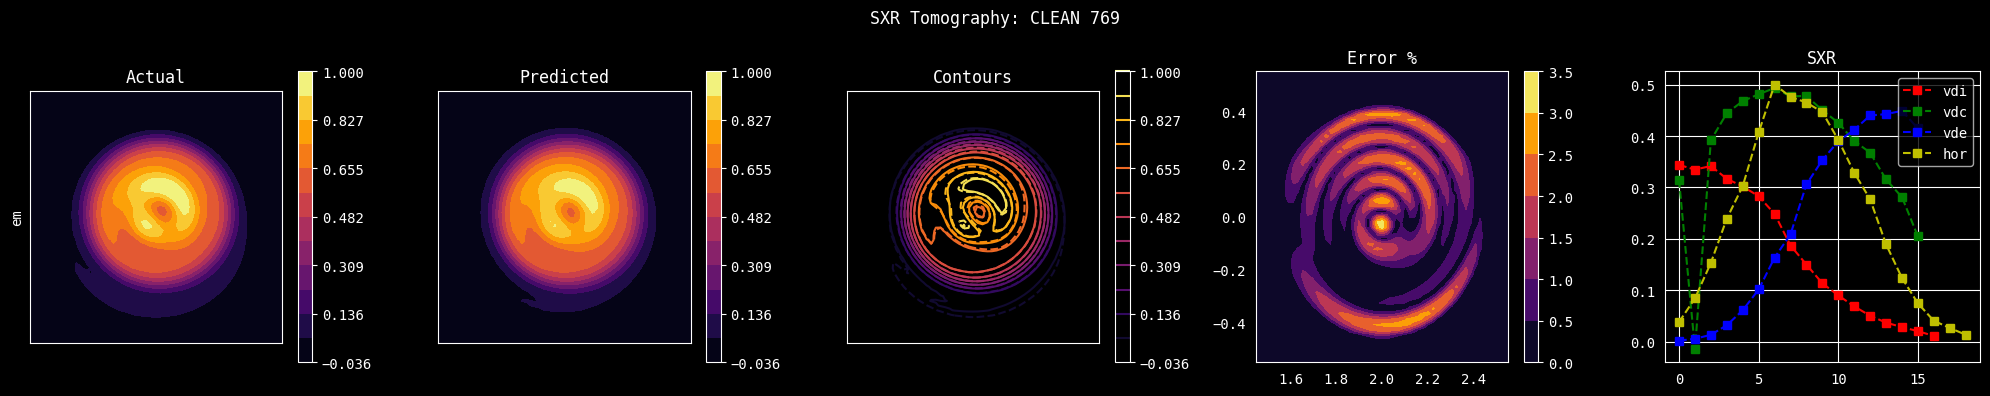

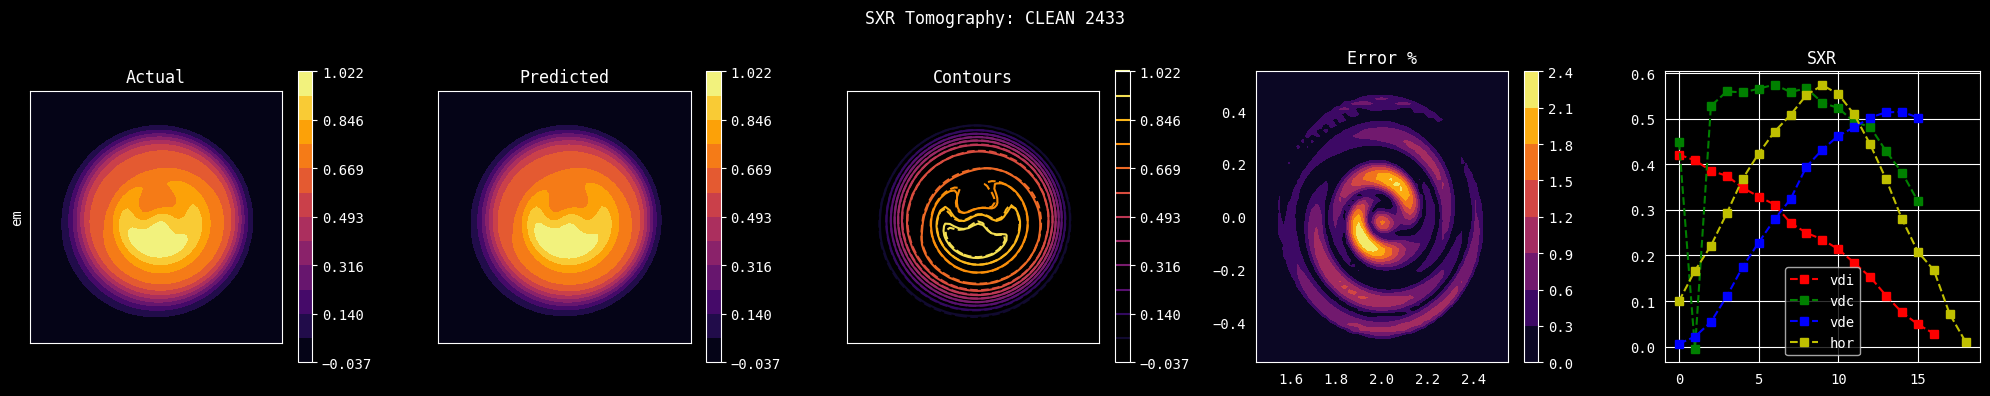

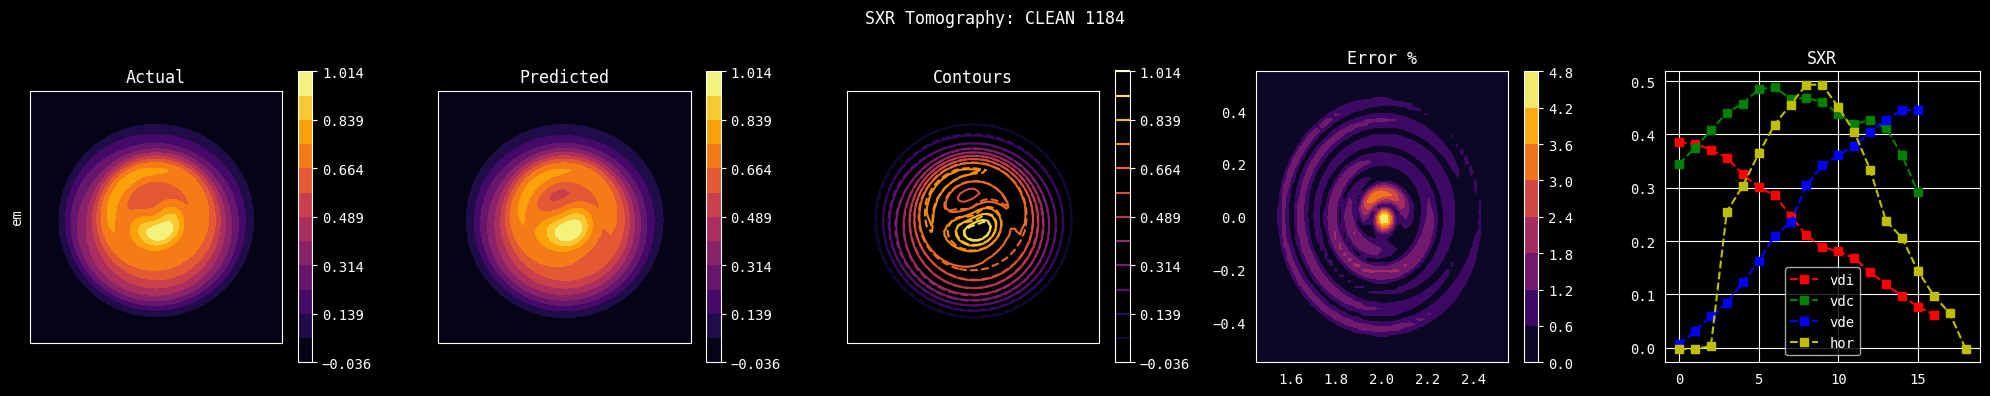

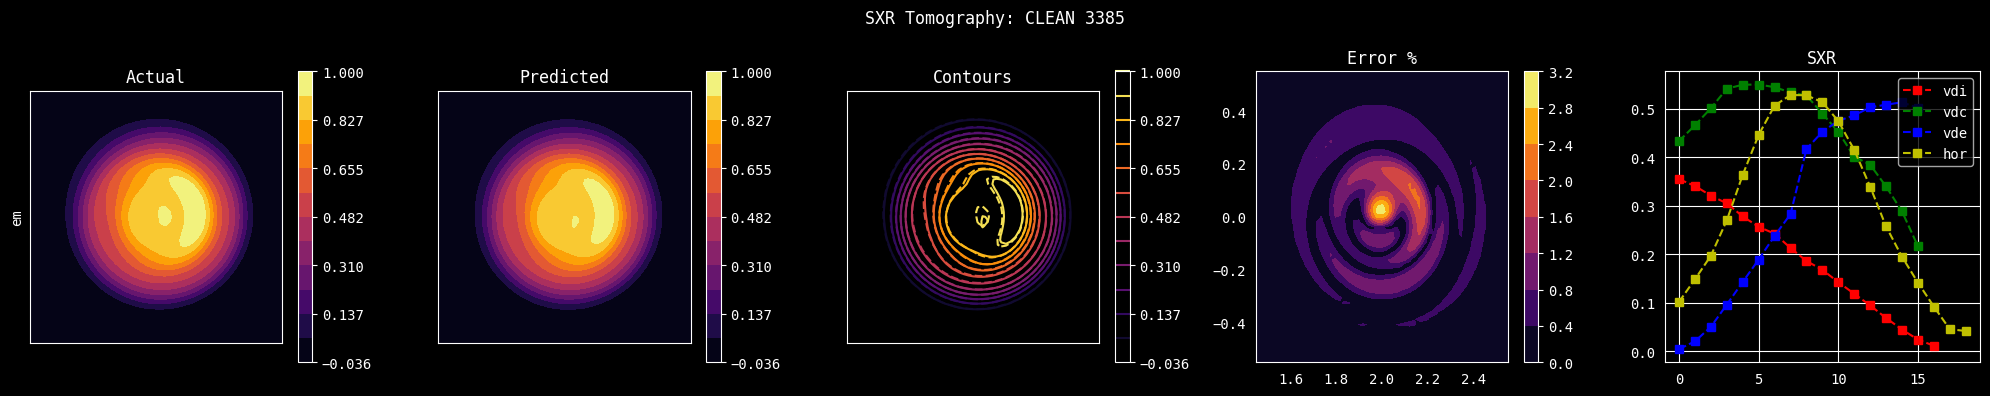

In [7]:
# testing clean data network output
model = ARCHITECTURE(ISIZE, GSIZE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=torch.device("cpu")))
model.eval()
ds = SXRDataset(N_DS//10, GSIZE, USE_REAL_DS, ks=KS)
rr, zz = ds.RR, ds.ZZ # grid coordinates
vdi0, vdi1, vdc0, vdc1, vde0, vde1, hor0, hor1 = DS_SXR_SPLITS[0], DS_SXR_SPLITS[1], DS_SXR_SPLITS[1], DS_SXR_SPLITS[2], DS_SXR_SPLITS[2], DS_SXR_SPLITS[3], DS_SXR_SPLITS[3], DS_SXR_SPLITS[4]
for i in np.random.randint(0, len(ds), N_PLOTS):  
    sxr, em_ds = ds[i]
    em = em_ds.detach().cpu().numpy().reshape(GSIZE, GSIZE)*KS
    sxr, em_ds = sxr.to('cpu'), em_ds.to('cpu')
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1,GSIZE,GSIZE)
    # clean data
    em_pred = model(sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = sxr[0,vdi0:vdi1], sxr[0,vdc0:vdc1], sxr[0,vde0:vde1], sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"CLEAN {i}")

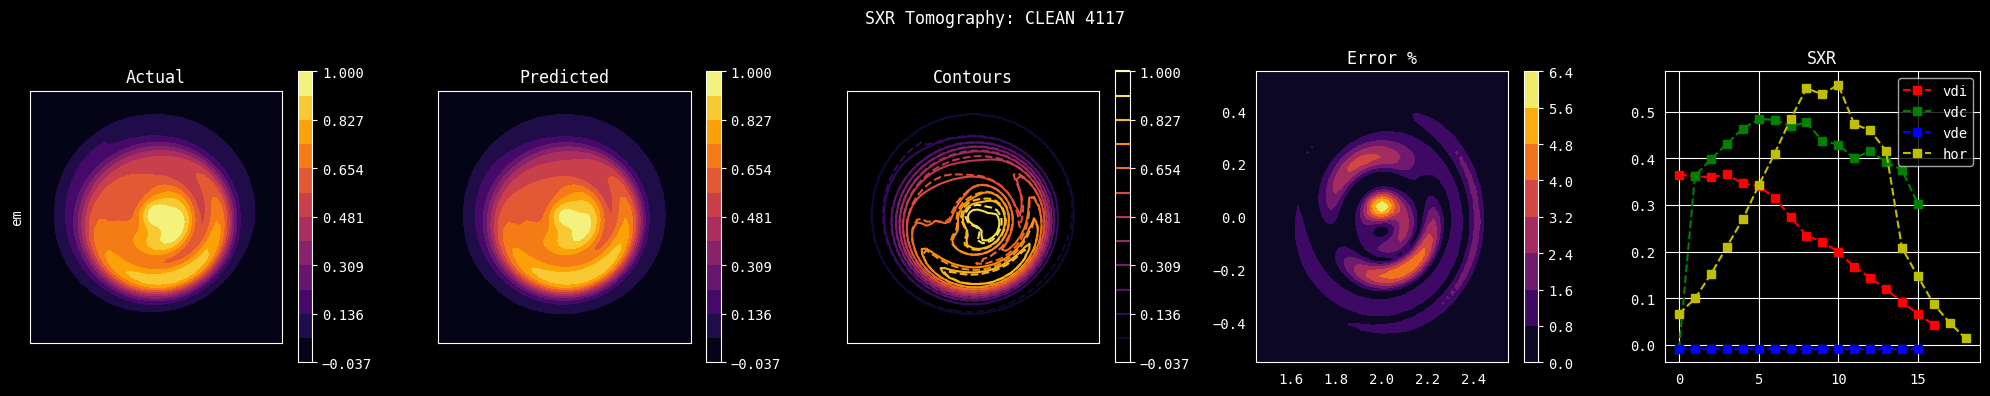

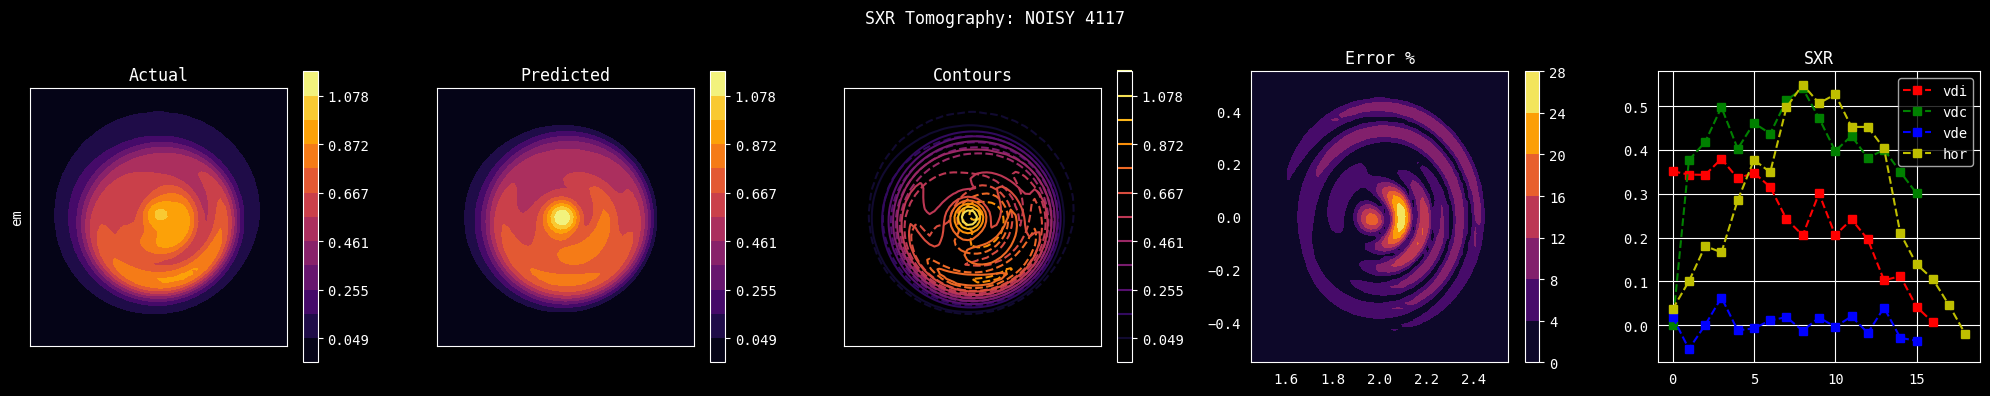

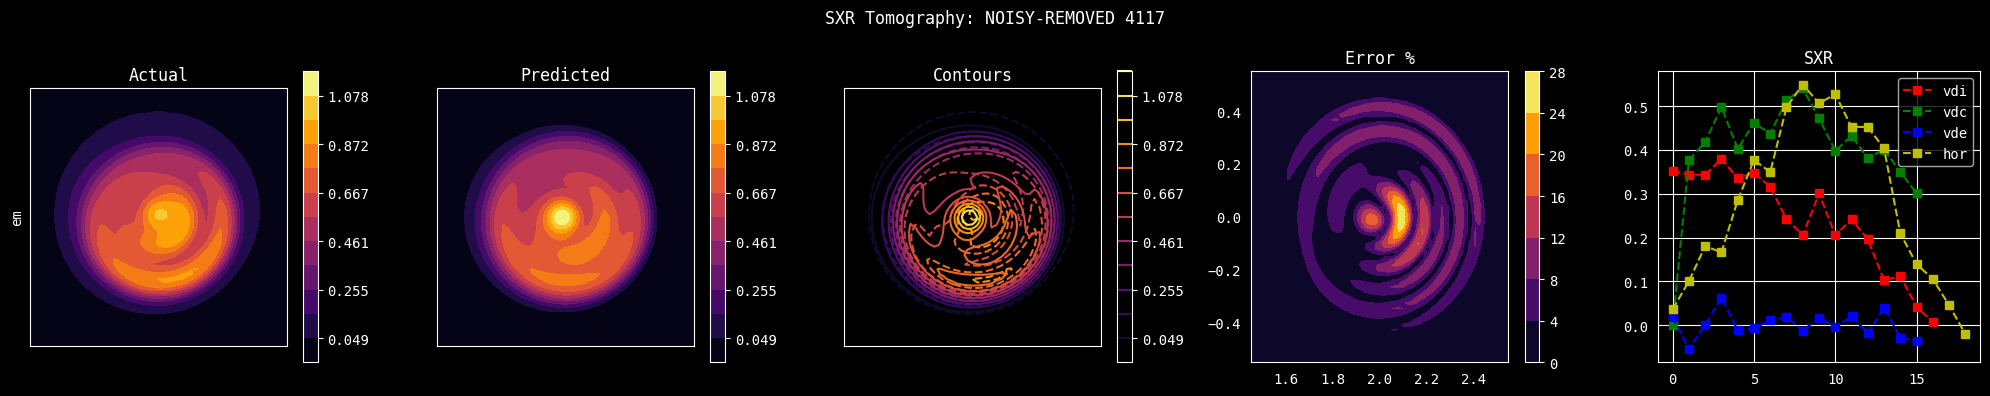

------------------------------------------------------------------------------------------


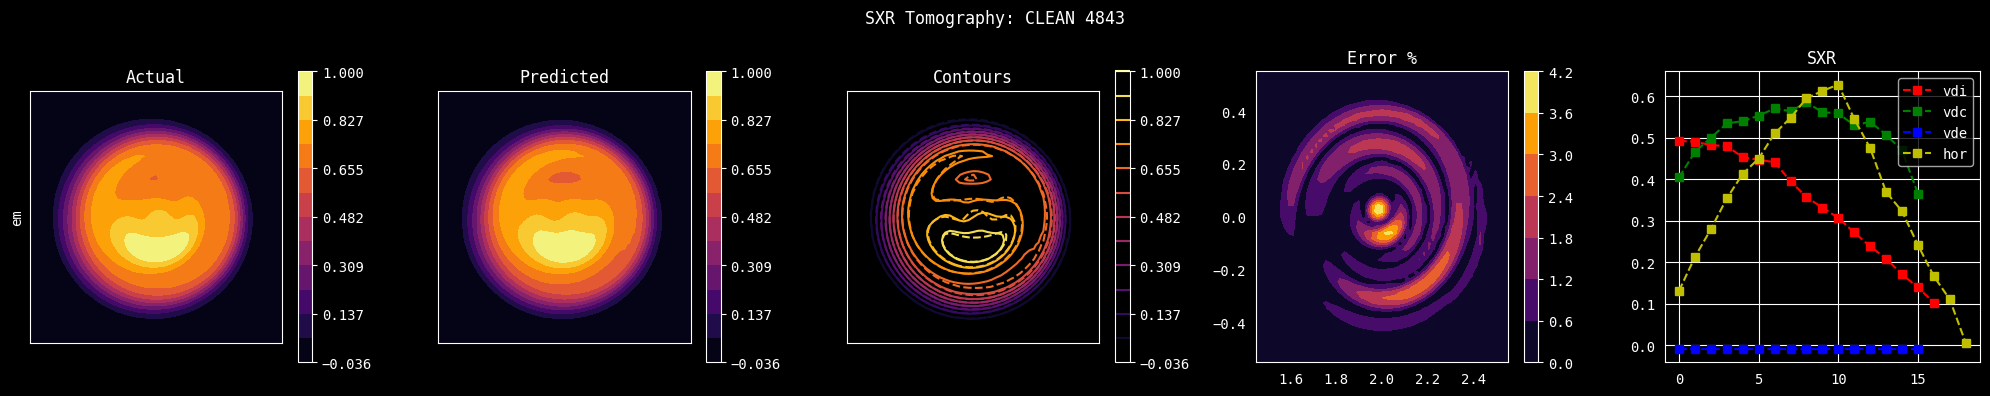

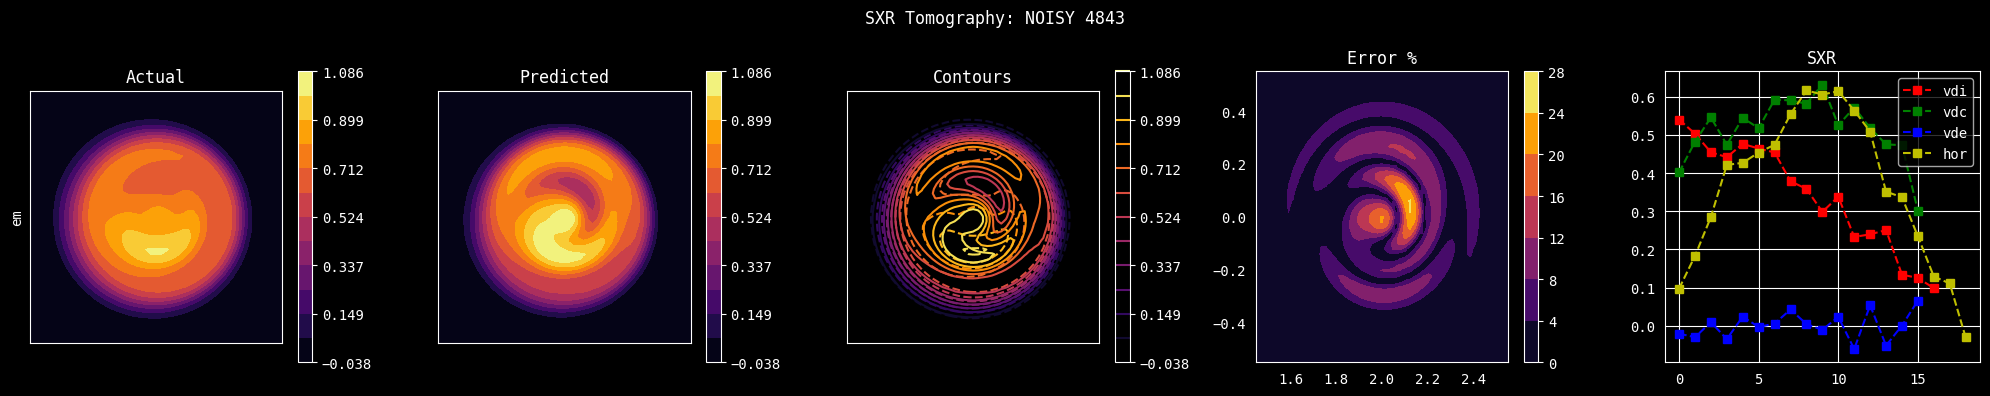

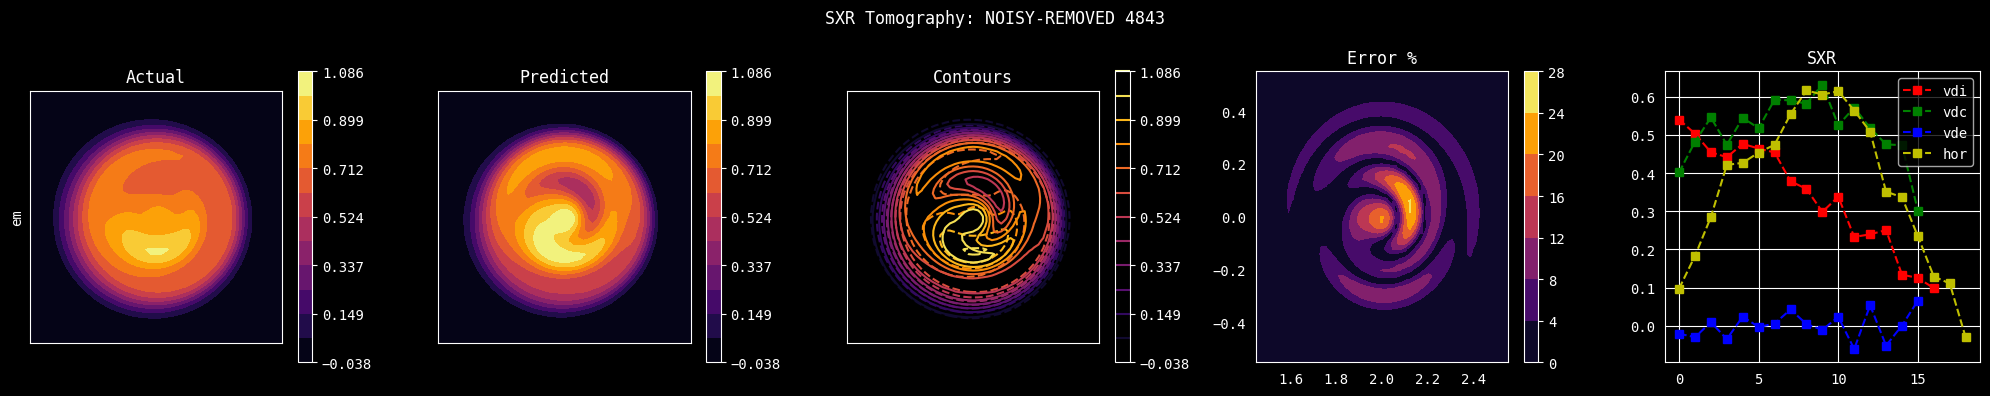

------------------------------------------------------------------------------------------


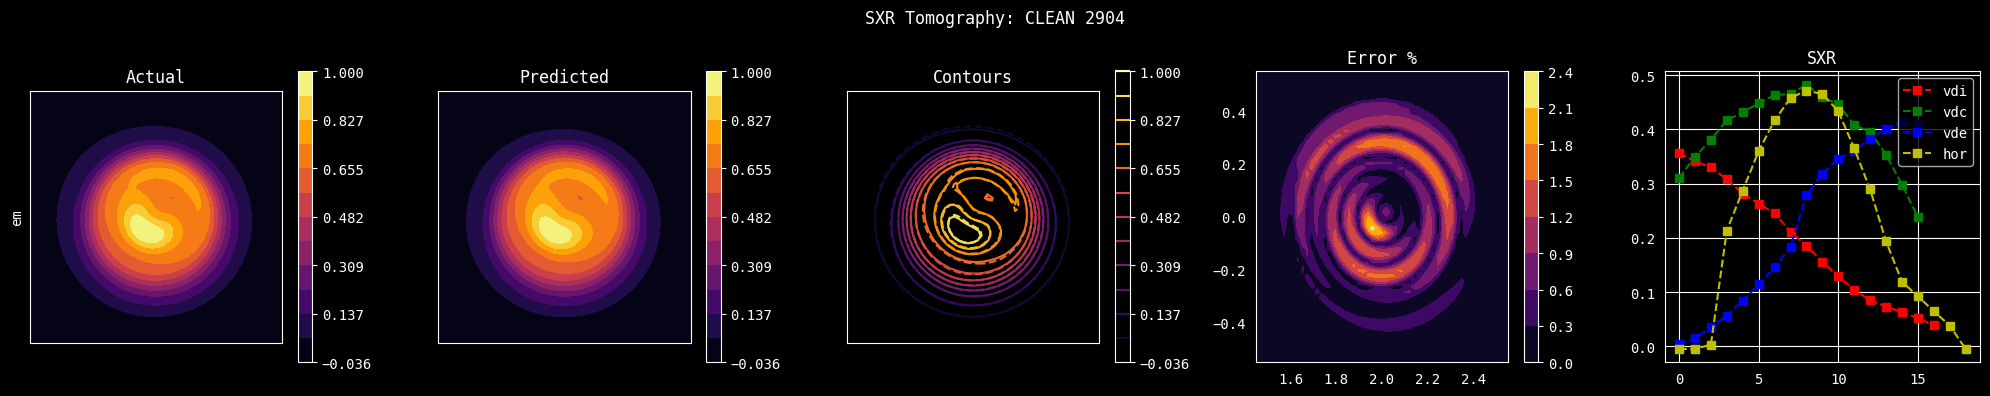

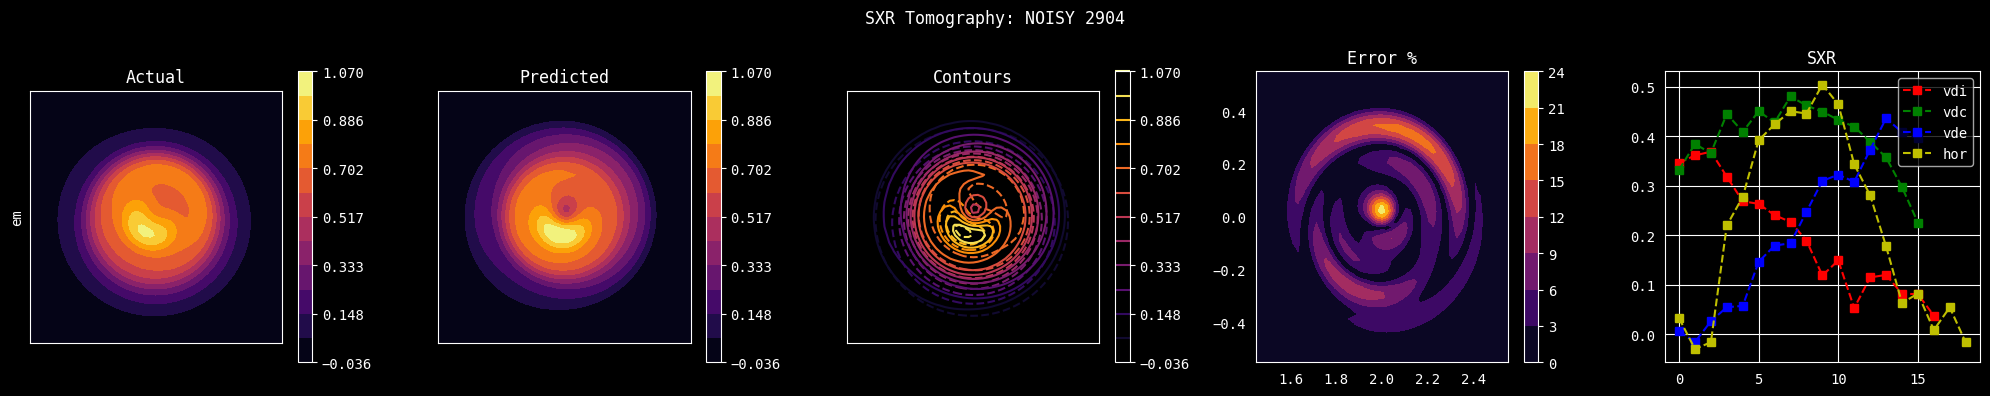

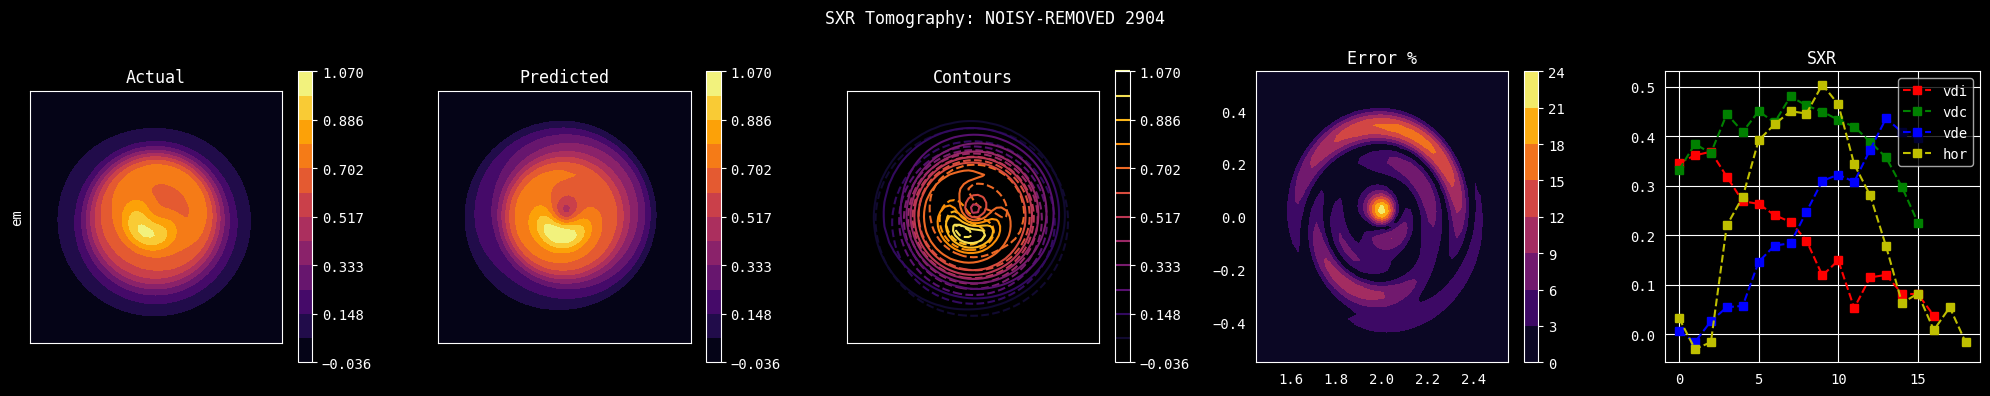

------------------------------------------------------------------------------------------


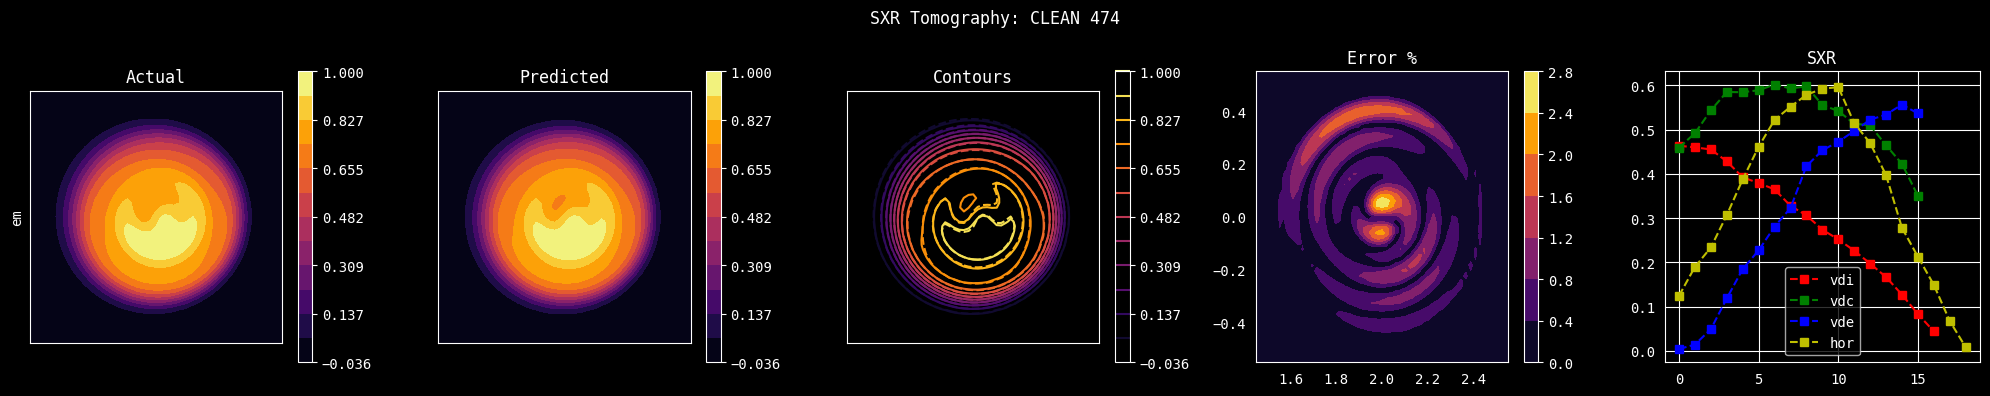

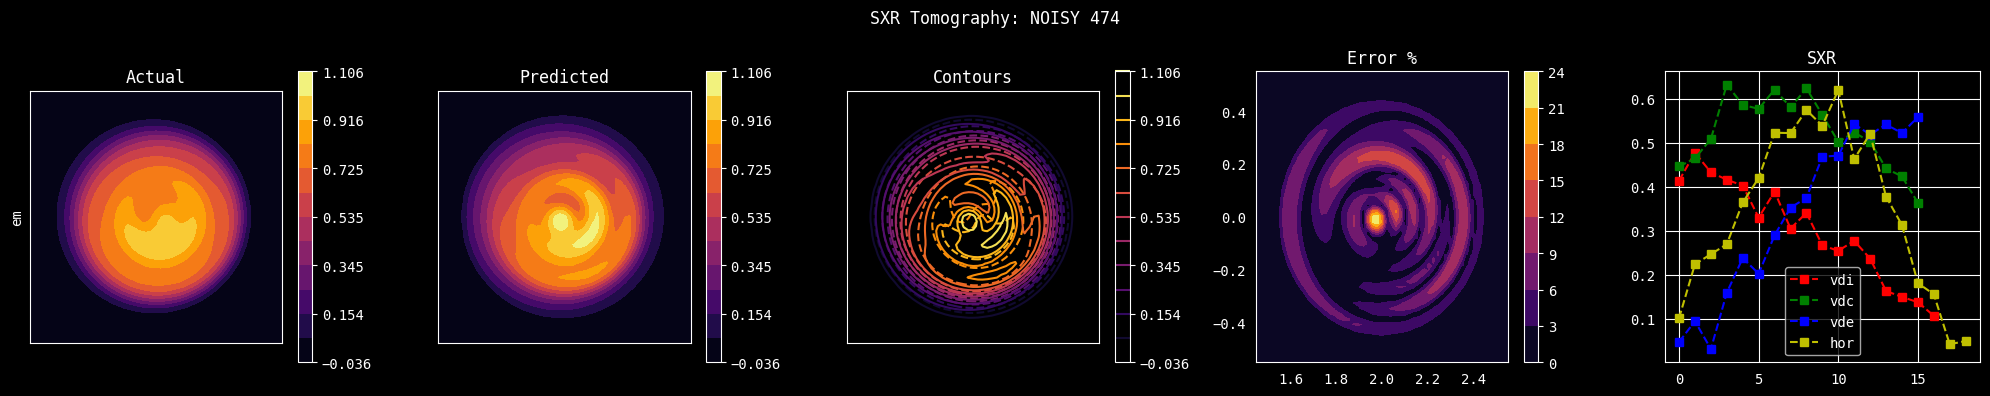

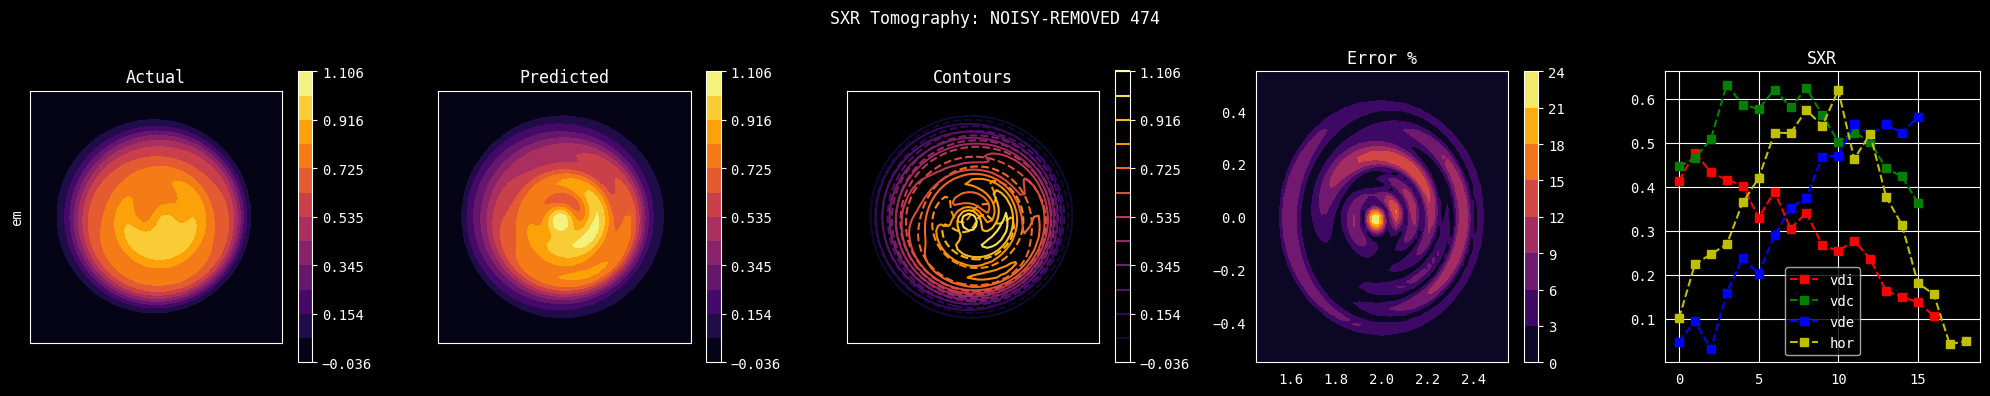

------------------------------------------------------------------------------------------


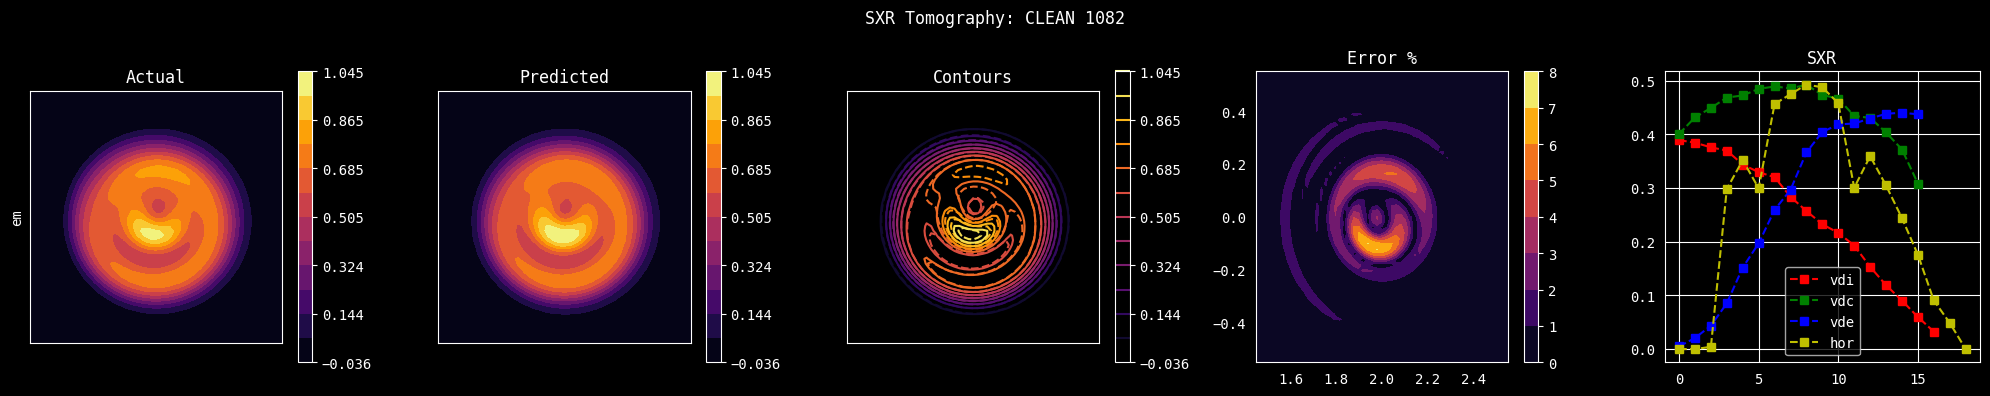

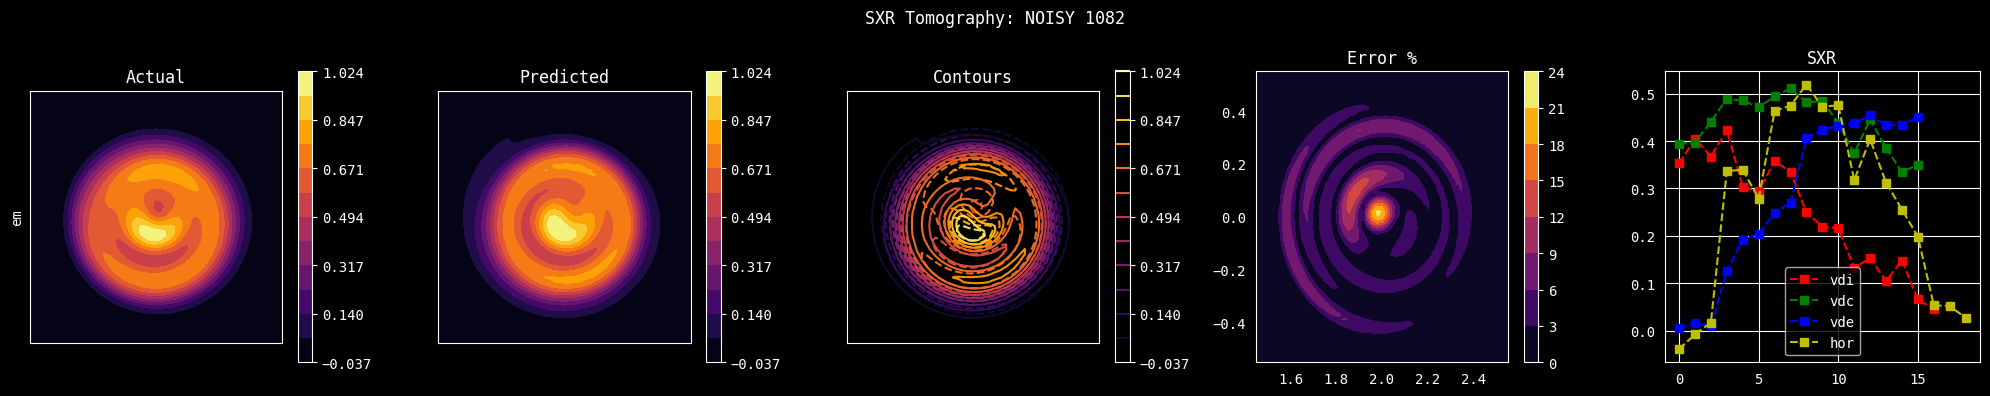

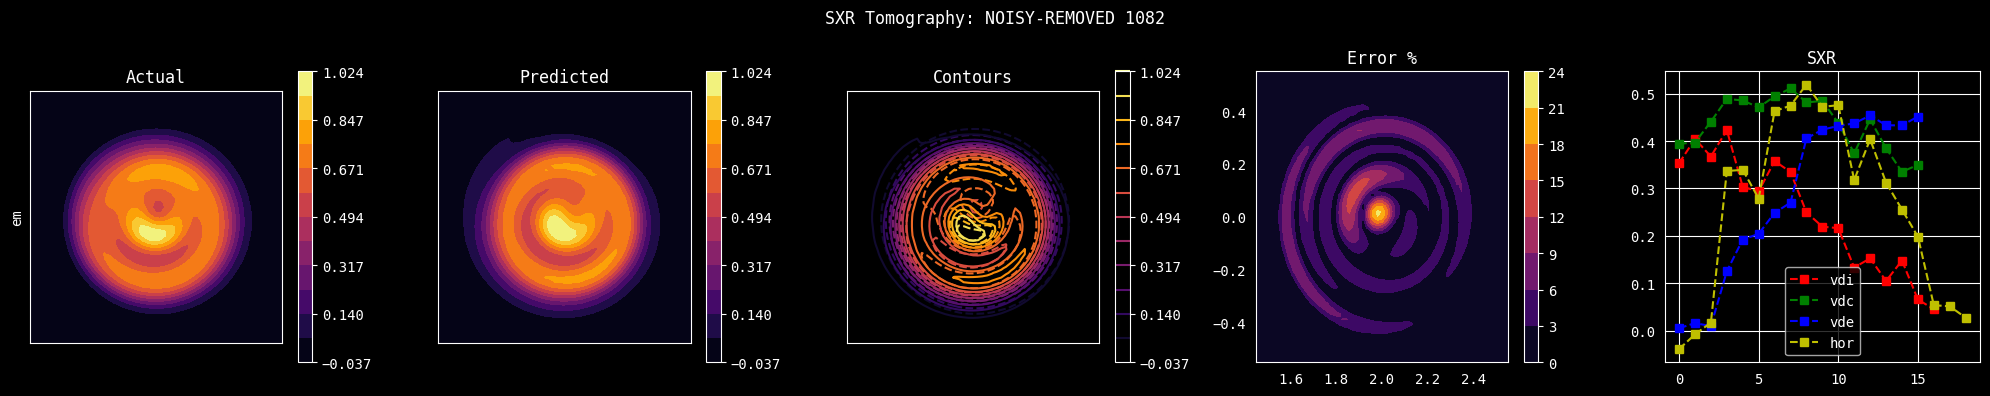

------------------------------------------------------------------------------------------


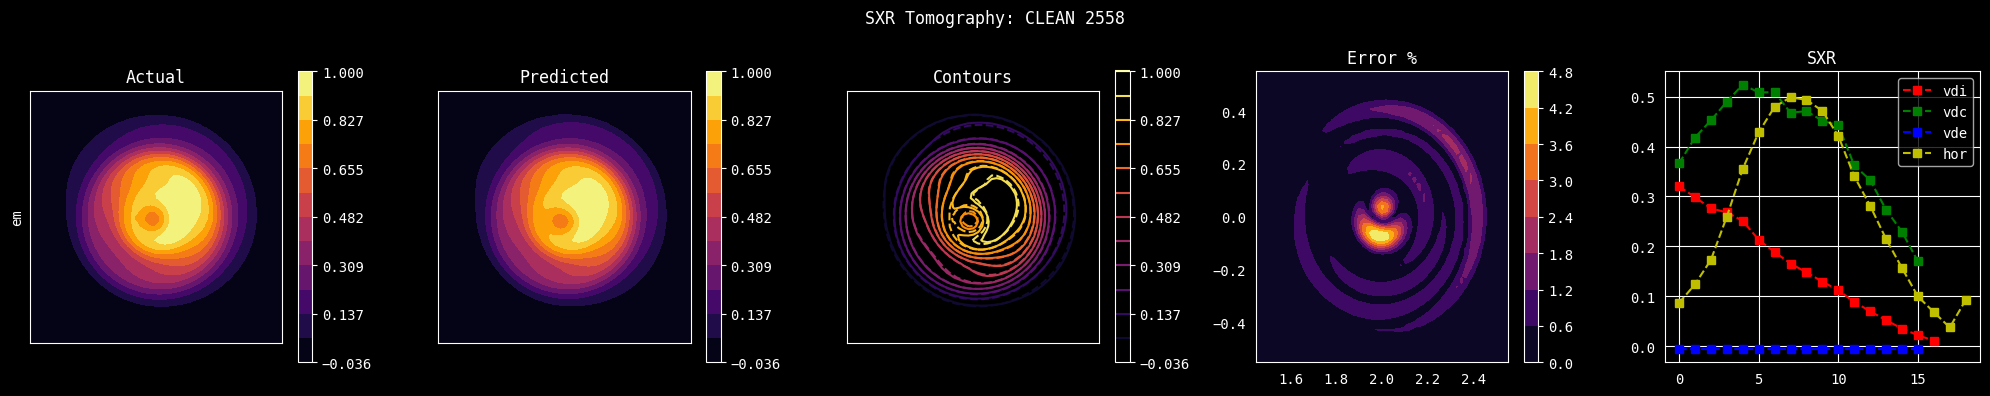

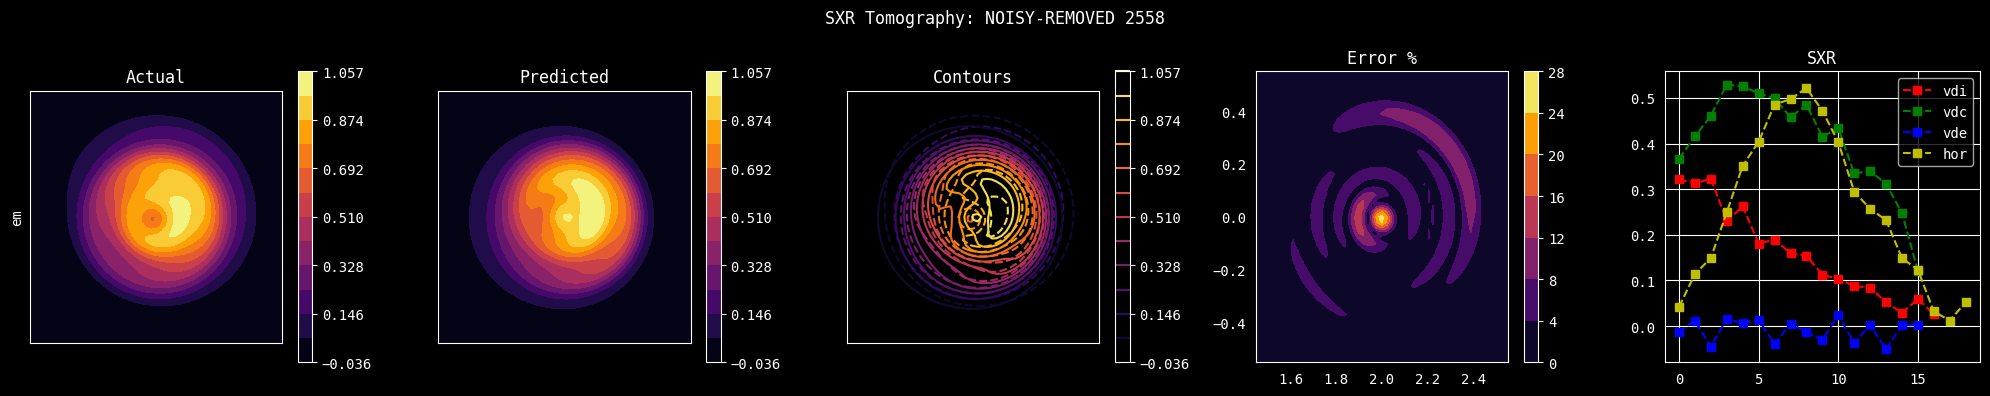

------------------------------------------------------------------------------------------


In [8]:
# testing noisy network output
model = ARCHITECTURE(ISIZE, GSIZE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=torch.device("cpu")))
model.eval()
ds = SXRDataset(N_DS//10, GSIZE, USE_REAL_DS, ks=KS)
rr, zz = ds.RR, ds.ZZ # grid coordinates
vdi0, vdi1, vdc0, vdc1, vde0, vde1, hor0, hor1 = DS_SXR_SPLITS[0], DS_SXR_SPLITS[1], DS_SXR_SPLITS[1], DS_SXR_SPLITS[2], DS_SXR_SPLITS[2], DS_SXR_SPLITS[3], DS_SXR_SPLITS[3], DS_SXR_SPLITS[4]
for i in np.random.randint(0, len(ds), N_PLOTS):  
    sxr, em_ds = ds[i]
    em = em_ds.detach().cpu().numpy().reshape(GSIZE, GSIZE)*KS
    sxr, em_ds = sxr.to('cpu'), em_ds.to('cpu')
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1,GSIZE,GSIZE)
    # clean data
    em_pred = model(sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = sxr[0,vdi0:vdi1], sxr[0,vdc0:vdc1], sxr[0,vde0:vde1], sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"CLEAN {i}")
    # noisy data
    noise = torch.randn_like(sxr) * 0.05 * torch.max(sxr)
    noisy_sxr = sxr + noise
    em_pred = model(noisy_sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = noisy_sxr[0,vdi0:vdi1], noisy_sxr[0,vdc0:vdc1], noisy_sxr[0,vde0:vde1], noisy_sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"NOISY {i}")
    # noisy data with random sensors removed
    noisy_sxr[0, np.random.randint(0, ISIZE, RANDOM_REMOVE)] = 0 # remove some sensors
    em_pred = model(noisy_sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = noisy_sxr[0,vdi0:vdi1], noisy_sxr[0,vdc0:vdc1], noisy_sxr[0,vde0:vde1], noisy_sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"NOISY-REMOVED {i}")
    print(f"------------------------------------------------------------------------------------------")

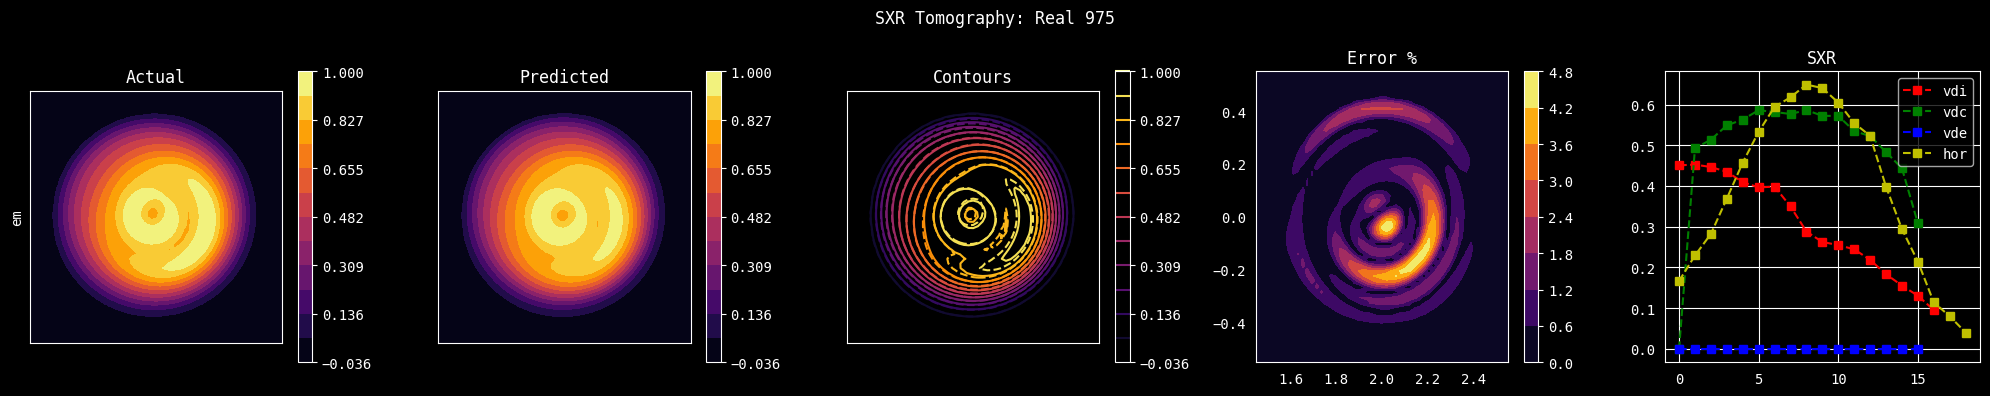

In [9]:
# test on REAL data
model = ARCHITECTURE(ISIZE, GSIZE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=torch.device("cpu")))
model.eval()
ds = SXRDataset(N_DS//10, GSIZE, real=True, ks=KS, calc_sxr=False)
rr, zz = ds.RR, ds.ZZ # grid coordinates
vdi0, vdi1, vdc0, vdc1, vde0, vde1, hor0, hor1 = DS_SXR_SPLITS[0], DS_SXR_SPLITS[1], DS_SXR_SPLITS[1], DS_SXR_SPLITS[2], DS_SXR_SPLITS[2], DS_SXR_SPLITS[3], DS_SXR_SPLITS[3], DS_SXR_SPLITS[4]
for i in np.random.randint(0, len(ds), N_PLOTS):  
    sxr, em_ds = ds[i]
    em = em_ds.detach().cpu().numpy().reshape(GSIZE, GSIZE)*KS
    sxr, em_ds = sxr.to('cpu'), em_ds.to('cpu')
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1,GSIZE,GSIZE)
    # clean data
    em_pred = model(sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = sxr[0,vdi0:vdi1], sxr[0,vdc0:vdc1], sxr[0,vde0:vde1], sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"Real {i}")

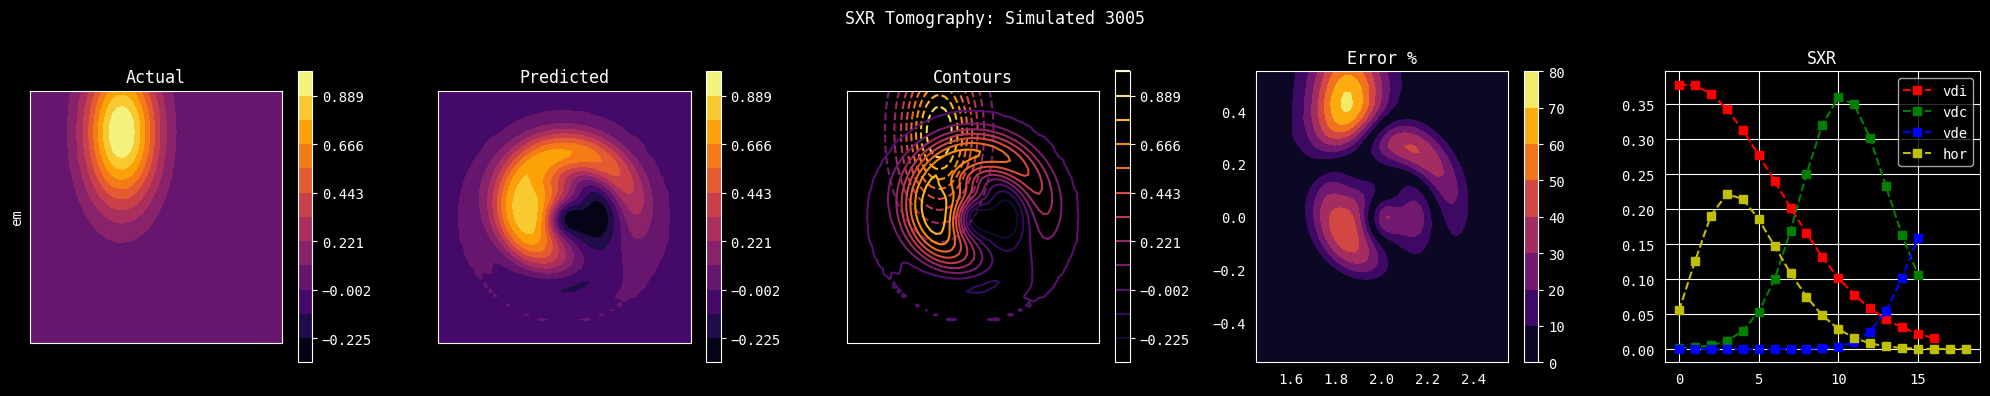

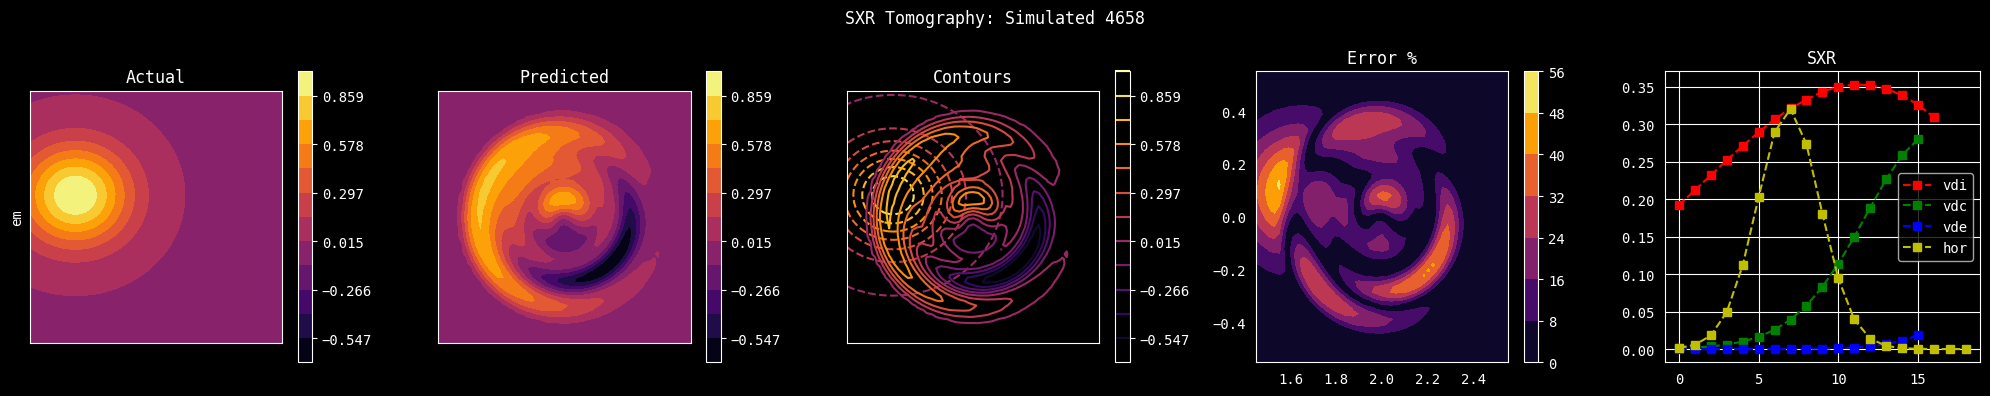

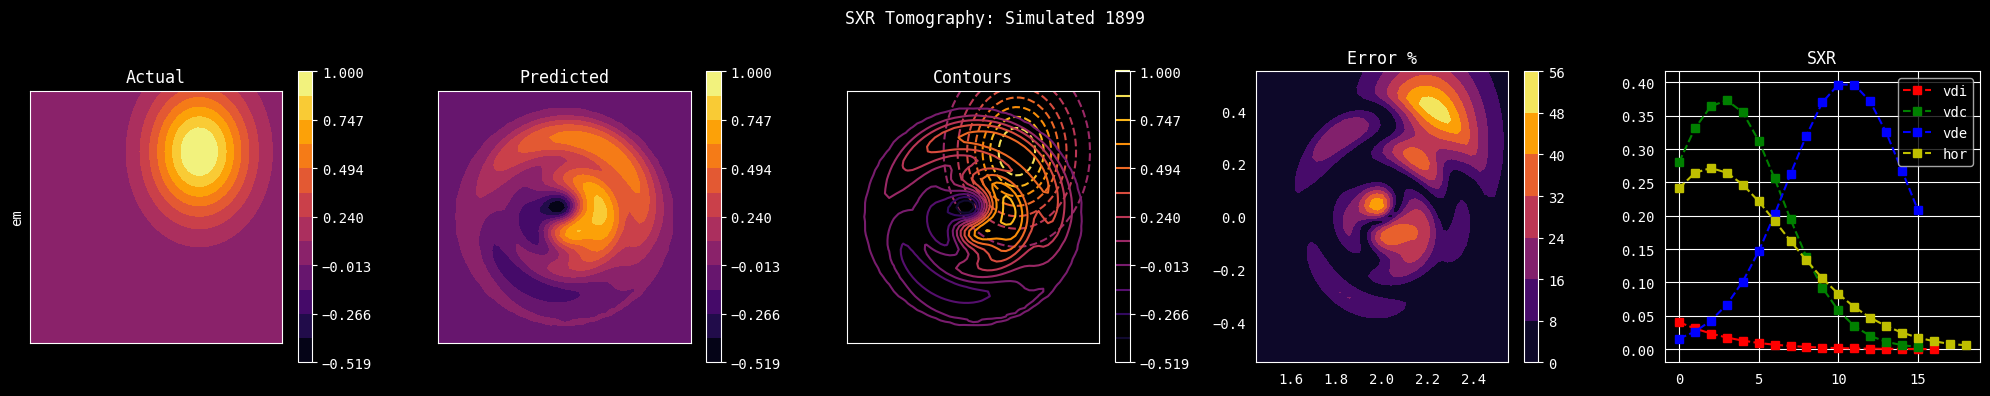

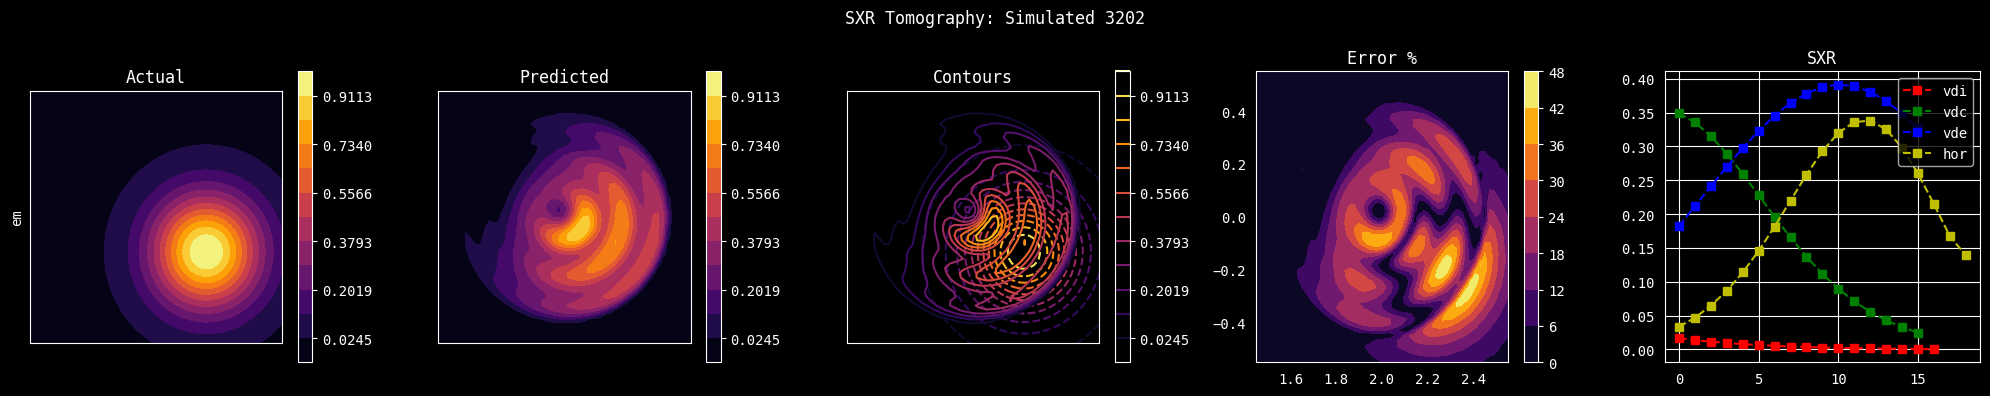

In [10]:
# test on SIM data
model = ARCHITECTURE(ISIZE, GSIZE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=torch.device("cpu")))
model.eval()
ds = SXRDataset(N_DS//10, GSIZE, real=False, ks=KS)
rr, zz = ds.RR, ds.ZZ # grid coordinates
vdi0, vdi1, vdc0, vdc1, vde0, vde1, hor0, hor1 = DS_SXR_SPLITS[0], DS_SXR_SPLITS[1], DS_SXR_SPLITS[1], DS_SXR_SPLITS[2], DS_SXR_SPLITS[2], DS_SXR_SPLITS[3], DS_SXR_SPLITS[3], DS_SXR_SPLITS[4]
for i in np.random.randint(0, len(ds), N_PLOTS):  
    sxr, em_ds = ds[i]
    em = em_ds.detach().cpu().numpy().reshape(GSIZE, GSIZE)*KS
    sxr, em_ds = sxr.to('cpu'), em_ds.to('cpu')
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1,GSIZE,GSIZE)
    # clean data
    em_pred = model(sxr).detach().numpy().reshape(GSIZE, GSIZE)*KS
    vdi, vdc, vde, hor = sxr[0,vdi0:vdi1], sxr[0,vdc0:vdc1], sxr[0,vde0:vde1], sxr[0,hor0:hor1]
    plot_net_example(em, em_pred, [vdi, vdc, vde, hor], rr, zz, f"Simulated {i}")

In [11]:
# test inference speed
model = ARCHITECTURE(ISIZE, GSIZE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=torch.device("cpu")))
model.eval()
ds = SXRDataset(N_DS//10, GSIZE, USE_REAL_DS, 0.0, ks=KS)
n_samples = 100
random_idxs = np.random.choice(n_samples, len(ds))
#cpu
cpu_times = []
for i in random_idxs:
    start_t = time()
    sxr, em_ds = ds[i]
    sxr, em_ds = sxr.to('cpu'), em_ds.to('cpu')
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1, GSIZE, GSIZE)
    em_pred = model(sxr)
    end_t = time()
    cpu_times.append(end_t - start_t) 
# DEV
model.to(DEV)
dev_times = []
for i in random_idxs:
    sxr, em_ds = ds[i]
    sxr, em_ds = sxr.view(1,-1), em_ds.view(1,1, GSIZE, GSIZE)
    start_t = time()
    em_pred = model(sxr)
    end_t = time()
    dev_times.append(end_t - start_t)    
cpu_times, dev_times = np.array(cpu_times), np.array(dev_times)
print(f"cpu: inference time: {1000*cpu_times.mean():.3f}[ms], std: {1000*cpu_times.std():.3f}[ms]")
print(f"dev: inference time: {1000*dev_times.mean():.3f}[ms], std: {1000*dev_times.std():.3f}[ms]")

cpu: inference time: 0.062[ms], std: 0.014[ms]
dev: inference time: 0.053[ms], std: 0.004[ms]
